# Определение стоимости автомобилей

**Цель проекта:** разработать модель машинного обучения, способную предсказывать рыночную стоимость автомобилей с пробегом на основе их технических характеристик и комплектации. Это позволит сервису "Не бит, не крашен" привлекать новых клиентов, предоставляя им возможность узнать ориентировочную цену своего автомобиля.

**Контекст:** сервис "Не бит, не крашен" стремится укрепить свои позиции на рынке подержанных автомобилей. Для этого компания разрабатывает приложение, которое поможет потенциальным клиентам узнать рыночную стоимость их автомобилей. Это предоставит пользователям прозрачную информацию о ценах и упростит процесс продажи и покупки.

Оценка качества моделей:
   * Оценка моделей с использованием метрики RMSE (Root Mean Squared Error).
   
Сравнение производительности моделей по следующим критериям:
   * Качество предсказания (RMSE): Чем меньше значение RMSE, тем лучше модель предсказывает цены. Цель - достичь RMSE менее 2500.
   * Время обучения: Время, затраченное на обучение модели.
   * Время предсказания: Время, затраченное на предсказание цены для одного автомобиля.

**Описание данных**

Данные находятся в файле /datasets/autos.csv.

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

**Библиотеки и константы**

In [1]:
!pip install --upgrade scikit-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import catboost
import lightgbm as lgb
import os

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

mpl.style.use(['bmh'])

import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE = 42

## Загрузка и подготовка данных

In [3]:
pth1 = 'autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
del pth1, pth2

Попробуем рассмотреть данные со всех сторон

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


На этапе предобработки данных необходимо выполнить следующие шаги: 
* Во-первых, переименовать названия столбцов, приведя их к змеиному регистру. 
* Во-вторых, удалить столбцы, которые, на мой взгляд, не несут значимой информации для обучения моделей. 

К таким столбцам относятся: 
  * DateCrawled (дата скачивания анкеты), 
  * DateCreated (дата создания анкеты), 
  * NumberOfPictures (количество фотографий автомобиля), 
  * PostalCode (почтовый индекс владельца анкеты),
  * LastSeen (дата последней активности пользователя)

In [6]:
df.shape

(354369, 16)

Довольно много данных)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных присутствуют пропуски. Далее, рассмотрим более внимательно их количество в процентном соотношении. Также стоит отметить, что типы данных в целом корректны. Единственное изменение, которое потребуется в дальнейшем, это преобразование типа данных столбца RegistrationYear (год регистрации автомобиля) из object в datetime

In [8]:
round(df.isna().sum() / df.count() * 100, 2).sort_values(ascending=False)

Repaired             25.12
VehicleType          11.83
FuelType             10.23
Gearbox               5.93
Model                 5.89
DateCrawled           0.00
Price                 0.00
RegistrationYear      0.00
Power                 0.00
Kilometer             0.00
RegistrationMonth     0.00
Brand                 0.00
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

Уделим больше внимания анализу пропусков в данных на этапе предобработки

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных обнаружены аномальные значения. Например, минимальное значение RegistrationYear составляет 1000, а максимальное - 9999, что не соответствует реальным годам регистрации автомобилей. Также выявлены выбросы, такие как Power равное 20000. Подробный анализ этих аномалий будет проведен на этапе исследовательского анализа

In [10]:
df.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


Тут все ок🤷‍♂️

## Предобработка данных

Проверим данные на дубликаты. Если найдем, то удалим

In [11]:
df.duplicated().sum()

4

In [12]:
df = df.drop_duplicates()
print(df.duplicated().sum())

0


Удалим лишние признаки

In [13]:
print(f'До: {df.shape}')
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
print(f'После: {df.shape}')

До: (354365, 16)
После: (354365, 11)


Стандартизируем названия признаков, используя snake_case нотацию

In [14]:
new_columns = {
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'repaired'
}
df = df.rename(columns=new_columns)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Начнем обрабатывать пропуски. 

Вероятнее всего пропуски в признаке repaired (была машина в ремонте или нет) означает что машина не была в ремонте

In [15]:
df['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [16]:
df['repaired'] = df['repaired'].fillna('no')
df['repaired'].unique()

array(['no', 'yes'], dtype=object)

Предлагаю следующий подход: для всех признаков, содержащих пропуски (кроме обработанного ранее), добавим временный столбец с количеством пропусков в наблюдении. Если пропусков больше двух – удаляем наблюдение

In [17]:
df['nan_sum'] = df.apply(lambda row: row.isna().sum(), axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,nan_sum
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,no,1
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,1
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0


In [18]:
print(f'До: {df.shape[0]}')
df = df[df['nan_sum'] < 3]
print(f'После: {df.shape[0]}')

До: 354365
После: 344522


In [19]:
round(df.isna().sum(), 2).sort_values(ascending=False)

vehicle_type          28177
fuel_type             23672
model                 14241
gearbox               11912
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
repaired                  0
nan_sum                   0
dtype: int64

Для заполнения оставшихся пропусков предлагаю использовать модальные значения, так как соответствующие признаки являются категориальными

In [20]:
for column in ['vehicle_type', 'fuel_type', 'model', 'gearbox']:
    df[column] = df[column].fillna(df[column].mode()[0])
df = df.drop('nan_sum', axis=1)

Предлагаю рассмотреть уникальные значения, содержащиеся в каждом признаке, для обнаружения возможных неявных дубликатов

In [21]:
df.describe(include='object')

,vehicle_type,gearbox,model,fuel_type,brand,repaired
count,344522,344522,344522,344522,344522,344522
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,119531,278586,43012,239589,74850,309032


In [22]:
for column in ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'model']:
    print(f'{column}: {df[column].unique()} \n')

vehicle_type: ['sedan' 'coupe' 'suv' 'small' 'convertible' 'bus' 'wagon' 'other'] 

gearbox: ['manual' 'auto'] 

fuel_type: ['petrol' 'gasoline' 'lpg' 'other' 'hybrid' 'cng' 'electric'] 

brand: ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche' 'rover'
 'land_rover' 'trabant' 'lada'] 

repaired: ['no' 'yes'] 

model: ['golf' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe' 'passat'
 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett'
 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4

Неявных дубликатов нет

In [23]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

In [24]:
df['fuel_type'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

## Исследовательский и корреляционный анализ

Для визуализации распределения значений, разработаем функцию creating_graph, которая потребует на вход датафрейм (df) и название столбца (column), а также будет иметь необязательные аргументы: количество корзин (bins), параметр сортировки (sort), а также лимит выводимых данных (length).

In [25]:
def creating_graph(df, column, bins=None, sort=False, lenth=None):
    """
    Визуализирует распределение данных в заданном столбце датафрейма.

  Args:
    df: pandas.DataFrame, датафрейм, содержащий данные.
    column: str, название столбца, для которого нужно построить визуализацию.
    bins: int, количество корзин для гистограммы.
    sort: bool, сортировка по категориям
    lenth: int, лимит выводимых данных

  Returns:
    Функция отображает график в зависимости от типа столбца (категориальный, дискретный, непрерывный).
    """
    if not bins:
        bins = df.shape[0] // 3000

    if df[column].nunique() <= 250:#категориальный / дискретный
        print(df[column].describe())
        if sort:
            pivot_table = df.pivot_table(index=column, 
                                   aggfunc='size').sort_values(ascending=False)[:lenth] 
        else:
            pivot_table = df.pivot_table(index=column, 
                                   aggfunc='size')[:lenth]              
                
        ax = pivot_table.plot(kind='bar', figsize=(12, 8))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        plt.ylabel('Количество наблюдений')
        plt.title('Распределение признака ' + column)
            
    else:#непрерывный
        print(df[column].describe())
        
        fig = plt.figure(figsize=(12, 8))
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        
        ax_main = fig.add_subplot(grid[:-1, :-1])
        ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])
        
        ax_main.hist(df[column], bins=bins, edgecolor='black')
        sns.boxplot(x=df[column], ax=ax_bottom)
        ax_main.set(title='Распределение признака ' + column, ylabel='Количество наблюдений')
    plt.show()

**price - цена (евро)**

count    344522.000000
mean       4494.928266
std        4527.191229
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


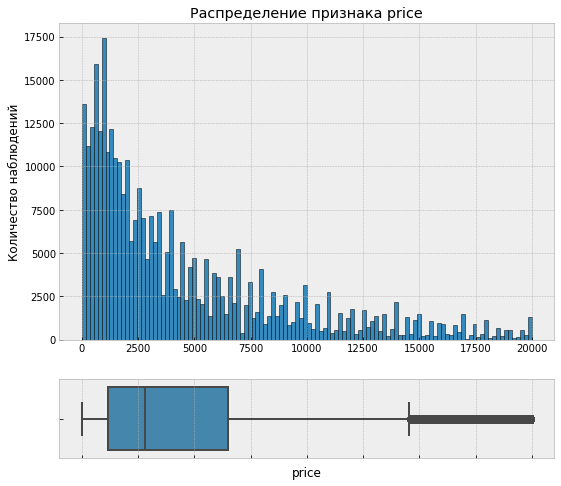

In [26]:
creating_graph(df, 'price')

Наблюдение минимальной стоимости в 0 вызывает вопросы. Вероятно, цены указаны в альтернативной валюте. Предлагаю скорректировать нижнюю границу ценового диапазона до 200 евро, в то время как максимальная цена в 20 000 евро кажется вполне обоснованной

In [27]:
print(f'До: {df.shape[0]}')
df = df[df['price'] > 200]
print(f'После: {df.shape[0]}')

До: 344522
После: 328478


**vehicle_type - тип автомобильного кузова**

count     328478
unique         8
top        sedan
freq      113009
Name: vehicle_type, dtype: object


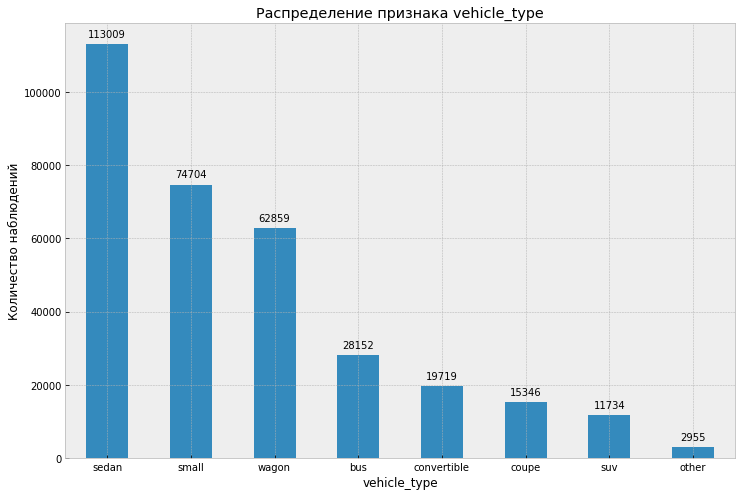

In [28]:
creating_graph(df, 'vehicle_type', sort=True)

Наиболее популярные типы кузова - это седан, компактный (или малый) и универсал

**registration_year -  год регистрации автомобиля**

Ввиду обнаружения аномальных значений года регистрации в пункте 1, предлагается ограничить данные диапазоном с 1950 по 2024 год

In [29]:
print(f'До: {df.shape[0]}')
df = df.loc[(df['registration_year'] > 1950) & (df['registration_year'] < 2017)]
print(f'После: {df.shape[0]}')

До: 328478
После: 316387


Выявим 10 лет, характеризующихся максимальным количеством регистраций автомобилей

count    316387.000000
mean       2002.737910
std           6.602315
min        1951.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64


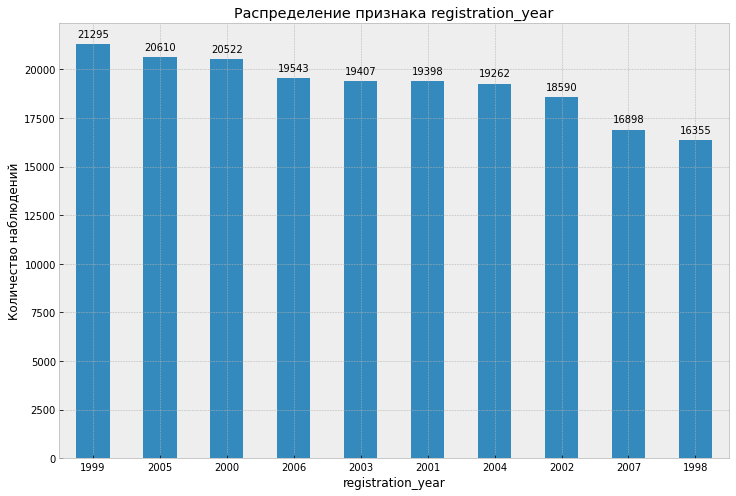

In [30]:
creating_graph(df, 'registration_year', sort=True, lenth=10)

Автомобили, зарегистрированные в период с 1998 по 2007 год, являются самыми продаваемыми

**gearbox - тип коробки передач**

count     316387
unique         2
top       manual
freq      254018
Name: gearbox, dtype: object


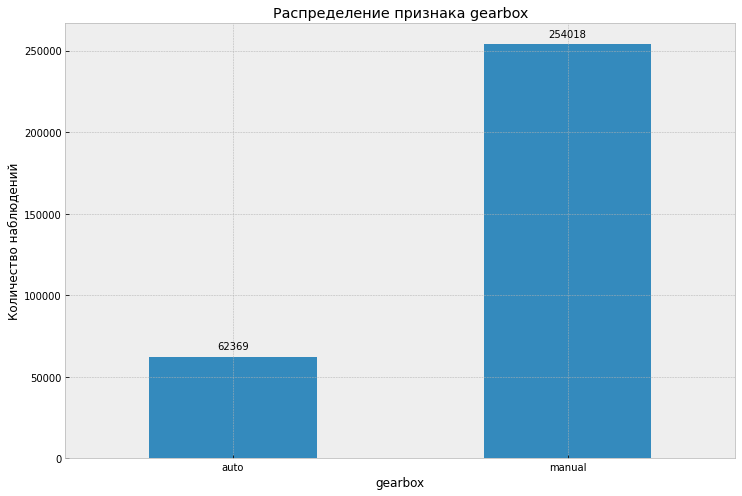

In [31]:
creating_graph(df, 'gearbox')

Наиболее распространенным типом трансмиссии является механическая коробка передач

**power - мощность (л. с.)**

count    316387.000000
mean        114.605309
std         184.072975
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


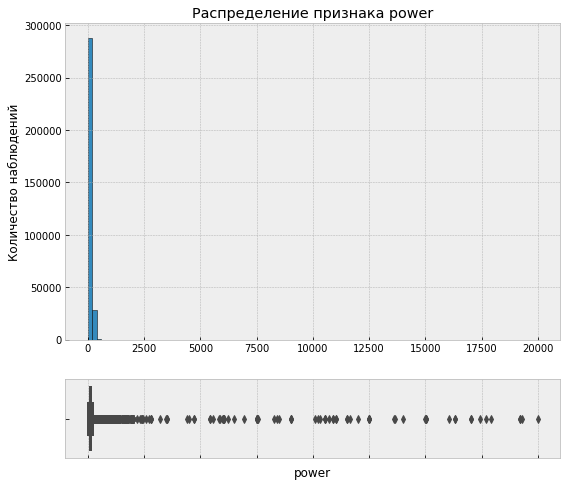

In [32]:
creating_graph(df, 'power')

На основании анализа интернет-ресурсов, установлен диапазон допустимой мощности автомобилей: от 15 л.с. (минимальное значение) до 1500 л.с. (максимальное значение, характерное для спорткаров)

In [33]:
print(f'До: {df.shape[0]}')
df = df[(df['power'] > 15) & (df['power'] < 1500)]
print(f'После: {df.shape[0]}')

До: 316387
После: 289732


В результате обработки данных количество наблюдений сократилось с исходных 354 369 до 298 952. Это означает, что было удалено 55 417 наблюдений, что составляет примерно 15.64% от первоначального набора данных

count    289732.000000
mean        121.912857
std          57.596627
min          16.000000
25%          80.000000
50%         114.000000
75%         150.000000
max        1436.000000
Name: power, dtype: float64


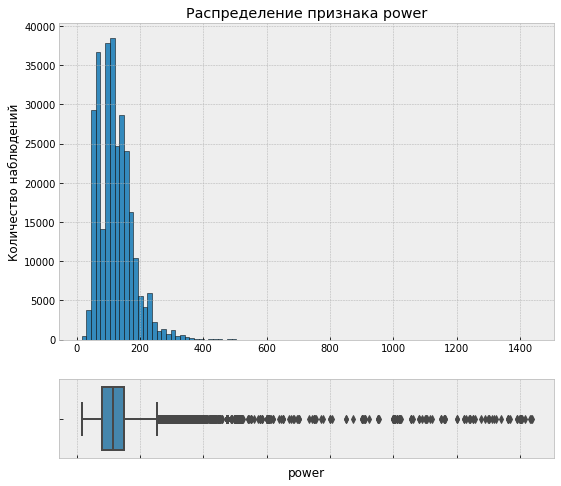

In [34]:
creating_graph(df, 'power')

**model - модель автомобиля**

count     289732
unique       249
top         golf
freq       33713
Name: model, dtype: object


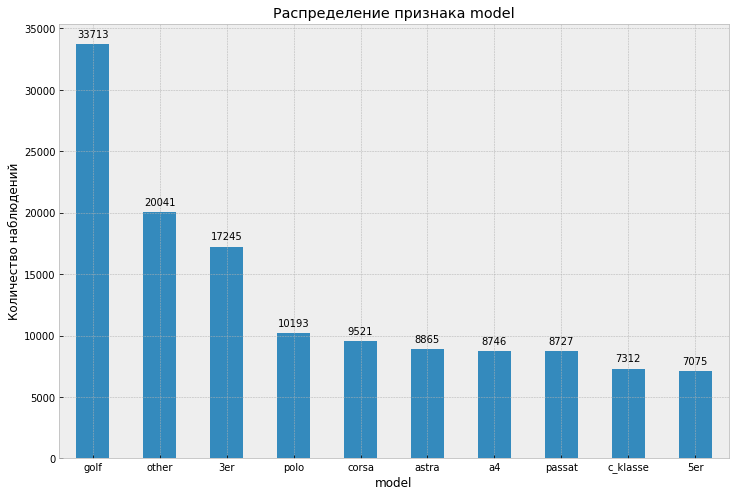

In [35]:
creating_graph(df, 'model', sort=True, lenth=10)

Модель Golf является самой популярной среди автомобилей

**kilometer - пробег (км)**

count    289732.000000
mean     128205.134400
std       36689.038721
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


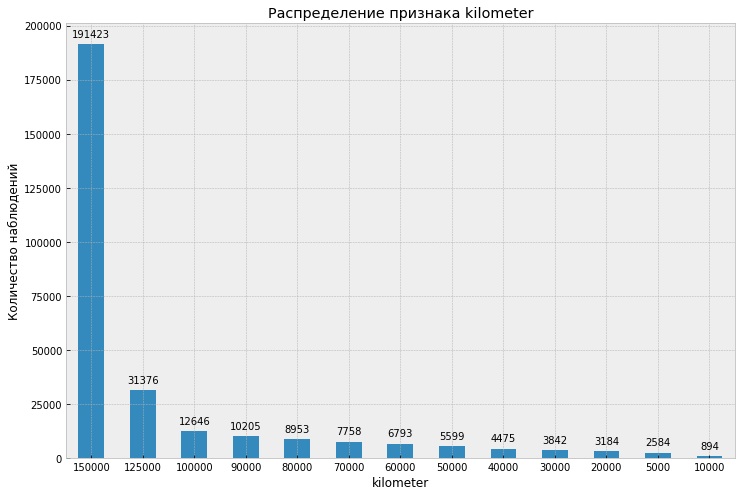

In [36]:
creating_graph(df, 'kilometer', sort=True)

Основная часть автомобилей имеет пробег около 150 000 км. Также следует отметить, что значения пробега представлены в дискретной форме, что, вероятно, является результатом округления

**registration_month - месяц регистрации автомобиля**

count    289732.000000
mean          6.032889
std           3.566381
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


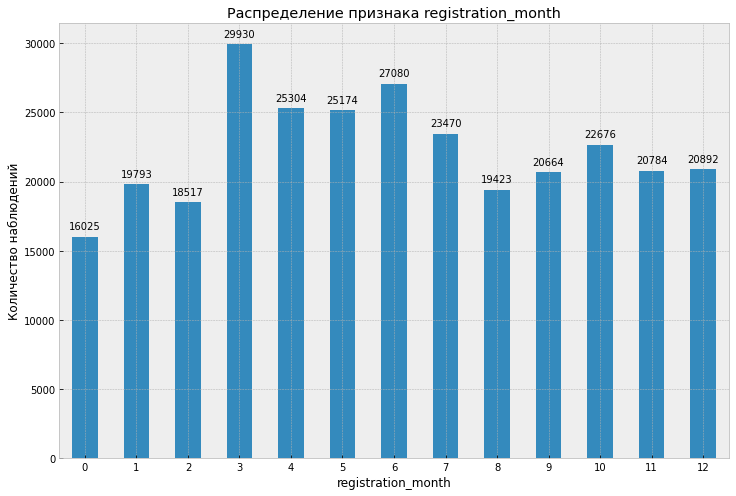

In [37]:
creating_graph(df, 'registration_month')

Поскольку нулевого месяца не существует, предлагается заменить все значения "0" в поле месяца на "1"

In [38]:
df['registration_month'] = df['registration_month'].replace(0, 1)

**fuel_type - тип топлива**

count     289732
unique         6
top       petrol
freq      284273
Name: fuel_type, dtype: object


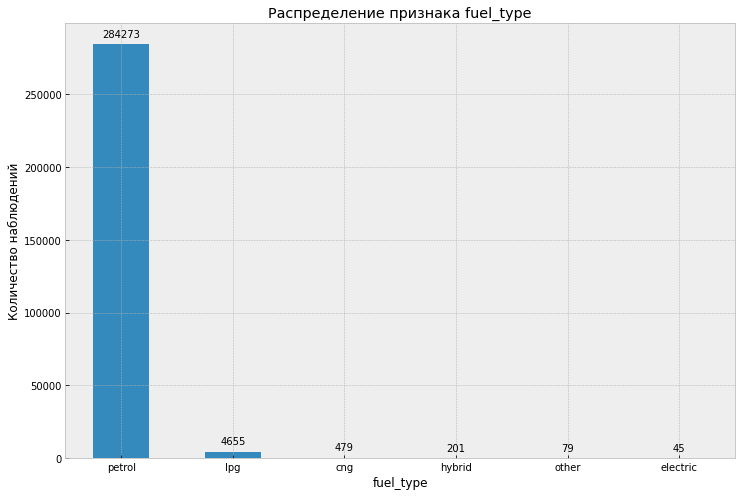

In [39]:
creating_graph(df, 'fuel_type', sort=True)

Наиболее распространенным видом топлива является бензин

**brand - марка автомобиля**

count         289732
unique            40
top       volkswagen
freq           62640
Name: brand, dtype: object


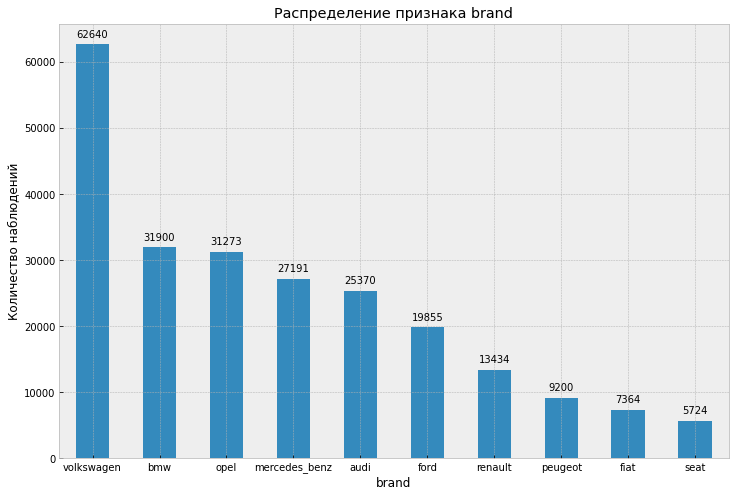

In [40]:
creating_graph(df, 'brand', sort=True, lenth=10)

Немецкая автомобильная промышленность занимает лидирующие позиции

**repaired -  была машина в ремонте или нет**

count     289732
unique         2
top           no
freq      262974
Name: repaired, dtype: object


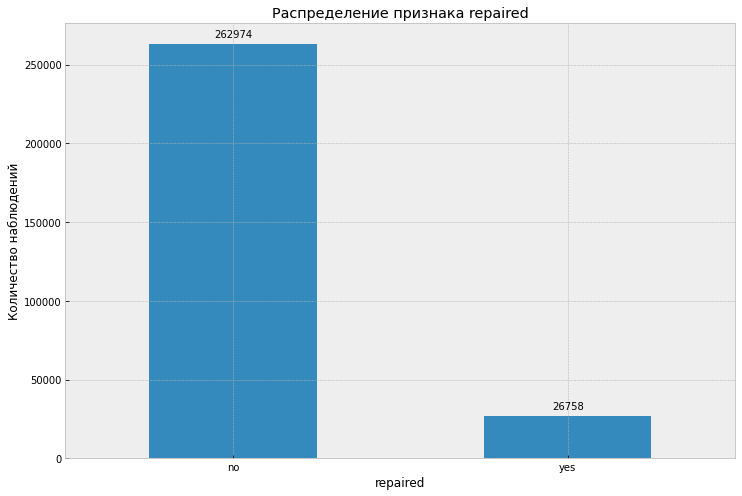

In [41]:
creating_graph(df, 'repaired')

Большая часть автомобилей не подвергалась ремонту

In [42]:
del creating_graph

**Корреляция**

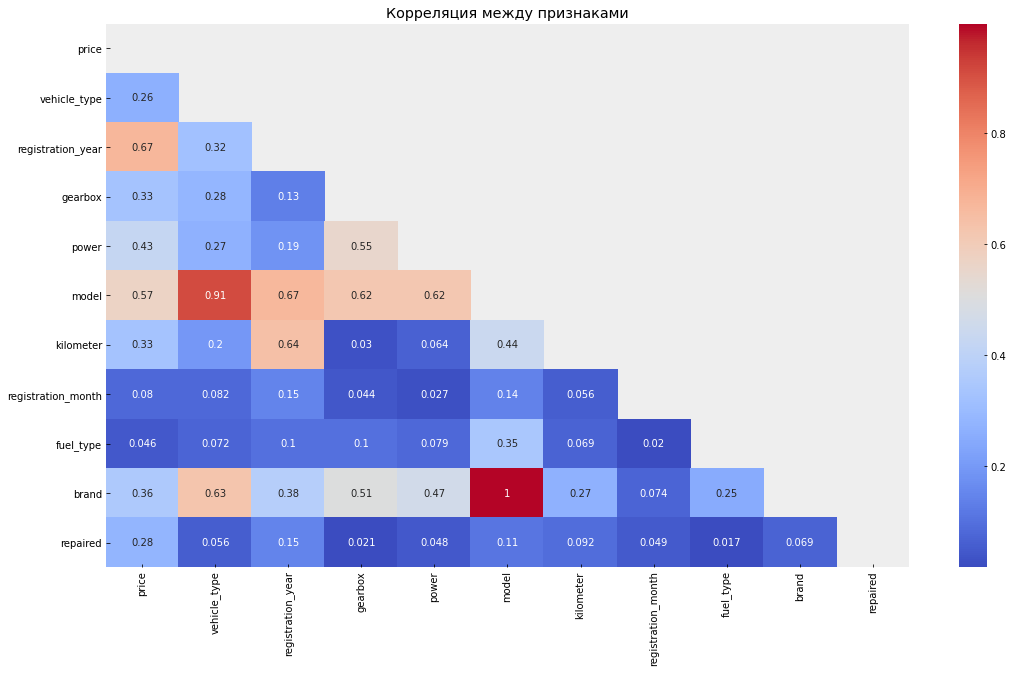

In [43]:
nam_col_names = ['price', 'power']

phik_matrix = df.phik_matrix(interval_cols=nam_col_names)

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(18, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Корреляция между признаками')
plt.show()

Ценовой признак (price) имеет самую высокую корреляцию с годом регистрации (0.67) и моделью автомобиля (0.57). Корреляция с типом топлива значительно ниже и составляет 0.046.

## Обучение моделей

В рамках данного исследования будет проведено обучение трех моделей машинного обучения: RandomForestRegressor, CatBoostRegressor и LGBMRegressor. Учитывая, что модель CatBoostRegressor не требует предварительного кодирования данных, будет подготовлено два набора данных: один с кодированием признаков, а другой без.

Данные о качестве предсказания, времени обучения и времени предсказания будут систематизированы в табличной форме для дальнейшего сравнения и анализа на следующем этапе.

In [1]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(df.drop('price', axis = 1),
                                                                df['price'],
                                                                test_size=0.4,
                                                                random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, 
                                                    y_test_valid,
                                                    test_size=0.5,
                                                    random_state=42) 

NameError: name 'train_test_split' is not defined

In [ ]:
low_card_cat_features = ['vehicle_type', 'fuel_type', 'brand', 'gearbox', 'repaired']
high_card_cat_features = ['model']
numeric_features = ['registration_year', 'power', 'kilometer', 'registration_month']

In [ ]:
%%time
col_transformer= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        low_card_cat_features
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        high_card_cat_features
    ),
    (
        StandardScaler(),
        numeric_features
    ),
    remainder='passthrough'
)

CPU times: user 77 µs, sys: 2 µs, total: 79 µs
Wall time: 83.2 µs


**RandomForestRegressor**

In [ ]:
%%time
final_model_rf = RandomForestRegressor(criterion='squared_error',
                                      random_state=RANDOM_STATE,
                                      n_estimators=100,
                                      max_depth=10,
                                      n_jobs=-1)

final_pipline_rf = make_pipeline(col_transformer, final_model_rf)

final_pipline_rf.fit(X_train, y_train)

CPU times: user 3min 9s, sys: 2.2 s, total: 3min 11s
Wall time: 3min 11s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicle_type', 'fuel_type',
                                                   'brand', 'gearbox',
                                                   'repaired']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_jobs=-1,
                                       random_state=42))])

In [ ]:
%%time
print("RandomForest:", np.sqrt(mean_squared_error(y_valid, final_pipline_rf.predict(X_valid))))

RandomForest: 1869.766599797443
CPU times: user 689 ms, sys: 3.91 ms, total: 693 ms
Wall time: 698 ms


**LGBMRegressor**

In [ ]:
%%time
lgbm_reg = LGBMRegressor(random_state=RANDOM_STATE)

pipline_lgbm = make_pipeline(col_transformer, lgbm_reg)

param_grid_lgbm = {
    'lgbmregressor__learning_rate': [0.1, 0.5],
    'lgbmregressor__max_depth': [5, 10]
}

gs_lgbm = RandomizedSearchCV(
    pipline_lgbm,
    param_distributions=param_grid_lgbm,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=RANDOM_STATE
)

gs_lgbm.fit(X_train, y_train)

gs_lgbm_best_score = gs_lgbm.best_score_ * -1
gs_lgbm_best_params = gs_lgbm.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END lgbmregressor__learning_rate=0.1, lgbmregressor__max_depth=5; total time= 2.8min
[CV] END lgbmregressor__learning_rate=0.1, lgbmregressor__max_depth=5; total time= 2.8min
[CV] END lgbmregressor__learning_rate=0.1, lgbmregressor__max_depth=5; total time= 2.4min
[CV] END lgbmregressor__learning_rate=0.1, lgbmregressor__max_depth=10; total time= 5.2min
[CV] END lgbmregressor__learning_rate=0.1, lgbmregressor__max_depth=10; total time= 3.3min
[CV] END lgbmregressor__learning_rate=0.1, lgbmregressor__max_depth=10; total time= 3.9min
[CV] END lgbmregressor__learning_rate=0.5, lgbmregressor__max_depth=5; total time= 3.9min
[CV] END lgbmregressor__learning_rate=0.5, lgbmregressor__max_depth=5; total time= 3.5min
[CV] END lgbmregressor__learning_rate=0.5, lgbmregressor__max_depth=5; total time= 3.0min
[CV] END lgbmregressor__learning_rate=0.5, lgbmregressor__max_depth=10; total time= 4.3min
[CV] END lgbmregressor__learning_rat

In [ ]:
print(gs_lgbm_best_score)
print(gs_lgbm_best_params)

1653.4463303014688
{'lgbmregressor__max_depth': 10, 'lgbmregressor__learning_rate': 0.5}


In [ ]:
%%time

lgbm_reg = LGBMRegressor(max_depth=gs_lgbm_best_params['lgbmregressor__max_depth'],
                         learning_rate=gs_lgbm_best_params['lgbmregressor__learning_rate'],
                         metric='rmse',
                         random_state=RANDOM_STATE)

pipline_lgbm = make_pipeline(col_transformer, lgbm_reg)

pipline_lgbm.fit(X_train, y_train)

CPU times: user 5min 32s, sys: 7.7 s, total: 5min 40s
Wall time: 5min 42s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicle_type', 'fuel_type',
                                                   'brand', 'gearbox',
                                                   'repaired']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.5, max_depth=10, metric='rmse',
                               random_state=42))])

In [ ]:
del gs_lgbm

In [ ]:
%%time
print("LightGBM:", np.sqrt(mean_squared_error(y_valid, pipline_lgbm.predict(X_valid))))

LightGBM: 1615.8000437032006
CPU times: user 503 ms, sys: 0 ns, total: 503 ms
Wall time: 500 ms


**CatBoostRegressor**

In [ ]:
df['vehicle_type'] = df['vehicle_type'].astype('category')
df['gearbox'] = df['gearbox'].astype('category')
df['model'] = df['model'].astype('category')
df['fuel_type'] = df['fuel_type'].astype('category')
df['brand'] = df['brand'].astype('category')
df['repaired'] = df['repaired'].astype('category')

In [ ]:
%%time
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

catboost = CatBoostRegressor(loss_function='RMSE')

parameters_cat = {
    'depth' : [5, 10],
    'learning_rate' : [0.1, 0.5]         
}

catboost_grid = catboost.grid_search(parameters_cat, 
                                     Pool(X_train, y_train, cat_features=cat_features),
                                     cv=3,
                                     plot=False)


0:	learn: 6222.1202411	test: 6202.8377160	best: 6202.8377160 (0)	total: 222ms	remaining: 3m 42s
1:	learn: 5719.1460450	test: 5701.3365389	best: 5701.3365389 (1)	total: 367ms	remaining: 3m 2s
2:	learn: 5283.1453682	test: 5267.3299238	best: 5267.3299238 (2)	total: 524ms	remaining: 2m 54s
3:	learn: 4892.1082674	test: 4878.9446591	best: 4878.9446591 (3)	total: 661ms	remaining: 2m 44s
4:	learn: 4548.7436196	test: 4537.5572255	best: 4537.5572255 (4)	total: 790ms	remaining: 2m 37s
5:	learn: 4239.6888970	test: 4231.7733067	best: 4231.7733067 (5)	total: 937ms	remaining: 2m 35s
6:	learn: 3973.3419090	test: 3966.5631247	best: 3966.5631247 (6)	total: 1.09s	remaining: 2m 34s
7:	learn: 3737.6650970	test: 3730.8514211	best: 3730.8514211 (7)	total: 1.23s	remaining: 2m 32s
8:	learn: 3527.3413084	test: 3516.8275576	best: 3516.8275576 (8)	total: 1.35s	remaining: 2m 28s
9:	learn: 3339.9584283	test: 3327.2958851	best: 3327.2958851 (9)	total: 1.48s	remaining: 2m 26s
10:	learn: 3180.6033151	test: 3167.126825

In [ ]:
catboost_params = catboost_grid['params']

In [ ]:
del catboost_grid

In [ ]:
%%time
final_cat = CatBoostRegressor(depth=catboost_params['depth'], 
                              learning_rate=catboost_params['learning_rate'],
                              loss_function='RMSE',
                              verbose=100)
final_cat.fit(Pool(X_train, 
                   y_train,
                   cat_features=cat_features))

0:	learn: 4281.0899176	total: 465ms	remaining: 7m 44s
100:	learn: 1634.9334973	total: 35.9s	remaining: 5m 19s
200:	learn: 1538.1956858	total: 1m 7s	remaining: 4m 28s
300:	learn: 1482.6854813	total: 1m 38s	remaining: 3m 49s
400:	learn: 1439.5005924	total: 2m 12s	remaining: 3m 17s
500:	learn: 1407.4534938	total: 2m 47s	remaining: 2m 46s
600:	learn: 1381.2514229	total: 3m 20s	remaining: 2m 13s
700:	learn: 1356.9703500	total: 3m 55s	remaining: 1m 40s
800:	learn: 1332.8784492	total: 4m 29s	remaining: 1m 7s
900:	learn: 1312.8201093	total: 5m 5s	remaining: 33.5s
999:	learn: 1292.9592723	total: 5m 39s	remaining: 0us
CPU times: user 5min 35s, sys: 5.82 s, total: 5min 40s
Wall time: 5min 43s


In [ ]:
%%time
print("CatBoost:", np.sqrt(mean_squared_error(y_valid, final_cat.predict(X_valid))))

CatBoost: 1533.60261625496
CPU times: user 1.09 s, sys: 37.1 ms, total: 1.13 s
Wall time: 1.14 s


Ниже приведены пересмотренные данные, касающиеся моделей

| Модель               | Время обучения | Время предсказания на y_valid | RMSE на y_valid        |
| -  | -  | - |-   |
| RandomForestRegressor | 3min 11s                  | 698 ms                         | 1869.766 |
| CatBoostRegressor   |  5min 43s  |   1.14 s      | 1533.60 |
| LGBMRegressor       |  5min 42s  |  500 ms      | 1615.80  |


Анализ моделей:

1.  RandomForestRegressor:
    *   RMSE: 1869.766 - Это хорошее значение, значительно ниже целевого в 2500.
    *   Время обучения: 3 минуты 11 секунд - Самое быстрое обучение из трех моделей.
    *   Время предсказания: 698 мс - Среднее время предсказания, медленнее, чем у LGBMRegressor, но быстрее, чем у CatBoostRegressor.

2.  CatBoostRegressor:
    *   RMSE: 1533.60 - Лучшее значение RMSE среди всех моделей, что говорит о наивысшем качестве предсказания.
    *   Время обучения: 5 минут 43 секунды - Самое долгое время обучения.
    *   Время предсказания: 1.14 с - Самое долгое время предсказания.

3.  LGBMRegressor:
    *   RMSE: 1615.80 - Значение RMSE немного выше, чем у CatBoostRegressor, но всё ещё в пределах хороших показателей.
    *   Время обучения: 5 минут 42 секунды - Время обучения примерно такое же, как у CatBoostRegressor.
    *   Время предсказания: 500 мс - Самое быстрое время предсказания.

Выбор лучшей модели:

Исходя из анализа, каждая модель имеет свои сильные и слабые стороны:

*   RandomForestRegressor - Это хороший компромисс между скоростью обучения и качеством предсказания. Однако, он не является лучшим ни в одном из этих показателей.
*   CatBoostRegressor - Показывает наивысшее качество предсказания, но имеет самое долгое время обучения и предсказания.
*   LGBMRegressor - Имеет хорошие показатели по качеству предсказания и самое быстрое время предсказания. Однако время обучения такое же, как и у CatBoostRegressor.
    
Я выбираю LGBMRegressor как лучшую модель, по следующим причинам: 
* он обеспечивает хороший баланс между качеством предсказания (RMSE = 1615.80) и скоростью предсказания (500 мс). 
* LGBMRegressor значительно быстрее CatBoostRegressor в предсказаниях

**RMSE лучшей модели**

In [ ]:
%%time
print("LightGBM:", np.sqrt(mean_squared_error(y_test, pipline_lgbm.predict(X_test))))

LightGBM: 1602.1118634032503
CPU times: user 574 ms, sys: 15.9 ms, total: 590 ms
Wall time: 582 ms


## Анализ моделей

Анализ результатов показал, что все протестированные модели продемонстрировали качество, превышающее установленные требования. Поскольку значение метрики RMSE для всех моделей оказалось значительно ниже целевого значения в 2500, дальнейшее сравнение моделей будет проводиться на основе их времени обучения и времени предсказания.

1. RandomForestRegressor

*   Время обучения: 7 минут 2 секунды (самое долгое из трех моделей)
*   Время предсказания: 4.35 секунды (самое долгое из трех моделей)
*   RMSE: 1582.78

2. CatBoostRegressor

*   Время обучения: 5 минут 47 секунд
*   Время предсказания: 923 миллисекунды
*   RMSE: 1545.79 (лучший RMSE из трех моделей)

3. LGBMRegressor

*   Время обучения: 4 минуты 4 секунды (самое быстрое время обучения)
*   Время предсказания: 811 миллисекунд (самое быстрое время предсказания)
*   RMSE: 1717.70 (худший RMSE из трех моделей)

Выбор лучшей и худшей моделей:

*   Лучшая модель: CatBoostRegressor является лучшей моделью, поскольку она имеет наименьшее значение RMSE (1545.79), что указывает на более высокую точность предсказаний, при этом время обучения и предсказания тоже достаточно хорошее.
*   Худшая модель: RandomForestRegressor является худшей моделью из-за самого высокого времени обучения.

Для дальнейшего повышения точности моделей я рекомендую применить комплексный подход. Во-первых, необходимо провести тщательную настройку гиперпараметров каждой модели, используя такие методы как Grid Search, Random Search или Bayesian optimization. Это позволит найти оптимальные параметры, которые наилучшим образом соответствуют нашим данным. Во-вторых, следует уделить внимание инженерии признаков – созданию новых, информативных признаков, например, путем комбинации существующих или использования полиномиальных трансформаций. Также, не менее важно провести комплексную предобработку данных, включая устранение пропусков, масштабирование и кодирование категориальных переменных. Наконец, для более надежной оценки производительности следует использовать кросс-валидацию.

Следует иметь в виду, что применение таких методов, как Grid Search, Random Search или Bayesian optimization для настройки гиперпараметров, а также использование кросс-валидации, может привести к увеличению общего времени обучения моделей.